## Problem Set 5 - Boston House Prices dataset

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
import random
from datetime import datetime
import sys
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt

In [2]:
# Loading boston dataset
boston = datasets.load_boston()
print(boston.keys())  # keys in data from sklearn
print(boston['DESCR'])  # Description of data

dict_keys(['data', 'target', 'feature_names', 'DESCR'])
Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,0

### Active Data Exploration

In [3]:
# Converting to dataframes

X = pd.DataFrame(boston.data)
Y = pd.DataFrame(boston.target)
X.columns = boston.feature_names  # Assigning names to features
Y.columns = ['MEDV']

In [4]:
# Exploring data
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [5]:
Y.head()

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


In [6]:
X.CHAS.value_counts()

0.0    471
1.0     35
Name: CHAS, dtype: int64

In [7]:
X.RAD.value_counts()

24.0    132
5.0     115
4.0     110
3.0      38
6.0      26
8.0      24
2.0      24
1.0      20
7.0      17
Name: RAD, dtype: int64

In [8]:
X.shape

(506, 13)

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


In [10]:
X.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [11]:
#Engineered features from existing features

X['CRIM_ZN']=np.multiply(X['CRIM'],X['ZN']) 
X['ZN_INDUS'] = np.multiply(X['ZN'],X['INDUS']) 
X['NOX_B'] = np.multiply(X['NOX'],X['B']) 
X['LSTAT_PTRATIO'] = np.multiply(X['LSTAT'],X['PTRATIO']) 
X['CRIM_B'] = np.multiply(X['CRIM'],X['B']) 
X['LSTAT_RM'] = np.multiply(X['LSTAT'],X['RM']) 
X['DIS_RM'] = np.multiply(X['DIS'],X['RM']) 
X['TAX_log'] = np.log(X['TAX'])
X['ZN_square'] = np.square(X['ZN'])
X['RAD_RM'] = np.multiply(X['RAD'],X['RM']) 

In [12]:
# generating new random features

Z = datasets.make_classification(n_samples=506,n_features=11, n_redundant=0,scale=5,n_informative=2,flip_y=0.5)    
Z = pd.DataFrame(Z[0], columns=['B0','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10']) # Assigning col names

In [13]:
X = pd.concat([X,Z],axis=1) # Concating new external features with exisitng dataframe

In [14]:
X.columns # Columns in new dataframe

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'CRIM_ZN', 'ZN_INDUS', 'NOX_B',
       'LSTAT_PTRATIO', 'CRIM_B', 'LSTAT_RM', 'DIS_RM', 'TAX_log', 'ZN_square',
       'RAD_RM', 'B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9',
       'B10'],
      dtype='object')

In [15]:
X.shape # Shape of new dataframe

(506, 34)

In [16]:
# Summary statistics

mean_stats = X.mean().to_frame('Mean') # Calculating mean for the dataframe
range_stats = (X.max()-X.min()).to_frame('Range') # Calculating range for the dataframe
missing_stats = X.isnull().sum().to_frame('Missing Values') # Calculating missing values for the dataframe

summary_stats = pd.concat([mean_stats,range_stats,missing_stats],axis=1) #Concatenating the above dataframes.

corr = {}
for i in X.columns:
    corr[i]=(Y['MEDV'].corr(X[i])) 
summary_stats['Corr'] = corr.values()

In [17]:
summary_stats

,Mean,Range,Missing Values,Corr
CRIM,3.593761,88.969880,0,-0.385832
ZN,11.363636,100.000000,0,0.360445
INDUS,11.136779,27.280000,0,-0.483725
CHAS,0.069170,1.000000,0,0.175260
NOX,0.554695,0.486000,0,-0.427321
RM,6.284634,5.219000,0,0.695360
AGE,68.574901,97.100000,0,-0.376955
DIS,3.795043,10.996900,0,0.249929
RAD,9.549407,23.000000,0,-0.381626
TAX,408.237154,524.000000,0,-0.468536


In [18]:
# Defining data and the target class

data = pd.concat([X,Y],axis=1) # Commbining target class with data
Y = data['MEDV']

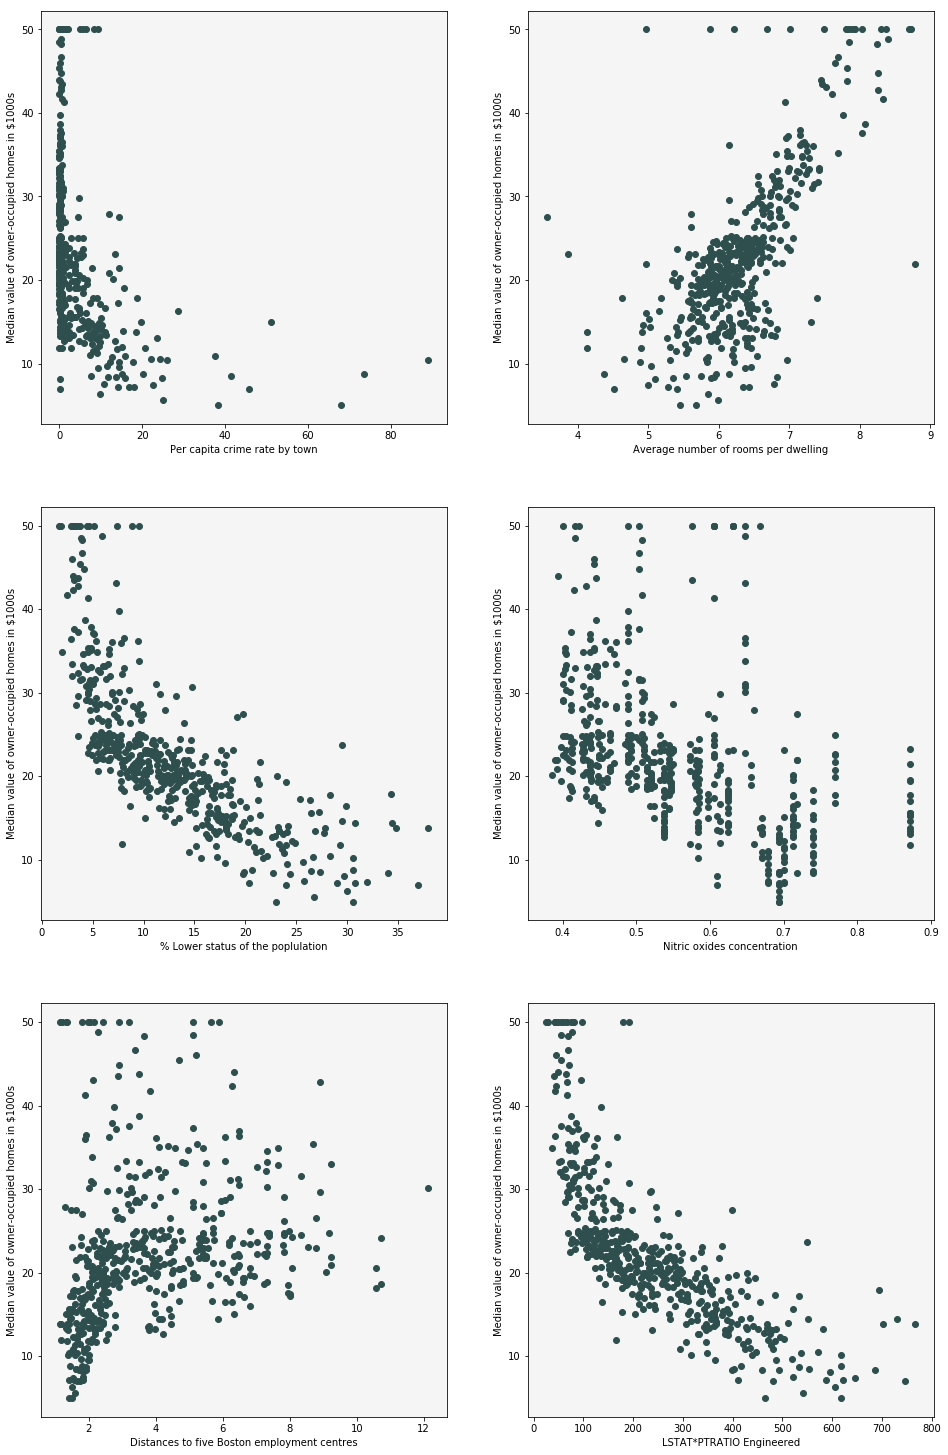

In [19]:
# Scatter Plot for features

#Relevant Features

plt.figure(figsize=(16,35))

# Plot 1 - Crime by Price
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.subplot(4,2,1)
plt.scatter(data['CRIM'],data['MEDV'],c='darkslategrey')
plt.xlabel('Per capita crime rate by town')
plt.ylabel('Median value of owner-occupied homes in $1000s')


# Plot 2 - No of rooms by Price
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.subplot(4,2,2)
plt.scatter(data['RM'],data['MEDV'],c='darkslategrey')
plt.xlabel('Average number of rooms per dwelling')
plt.ylabel('Median value of owner-occupied homes in $1000s')

# Plot 3 - % of lower status pop by price
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.subplot(4,2,3)
plt.scatter(data['LSTAT'],data['MEDV'],c='darkslategrey')
plt.xlabel('% Lower status of the poplulation')
plt.ylabel('Median value of owner-occupied homes in $1000s')

# Plot 4 - NO levels by Price
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.subplot(4,2,4)
plt.scatter(data['NOX'],data['MEDV'],c='darkslategrey')
plt.xlabel('Nitric oxides concentration')
plt.ylabel('Median value of owner-occupied homes in $1000s')

# PLot 5 - Distance to emp centers by Price
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.subplot(4,2,5)
plt.scatter(data['DIS'],data['MEDV'],c='darkslategrey')
plt.xlabel('Distances to five Boston employment centres')
plt.ylabel('Median value of owner-occupied homes in $1000s')

#Plot 6 - Pupil teacher ratio by price
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.subplot(4,2,6)
plt.scatter(data['LSTAT_PTRATIO'],data['MEDV'],c='darkslategrey')
plt.xlabel('LSTAT*PTRATIO Engineered')
plt.ylabel('Median value of owner-occupied homes in $1000s')



plt.show()


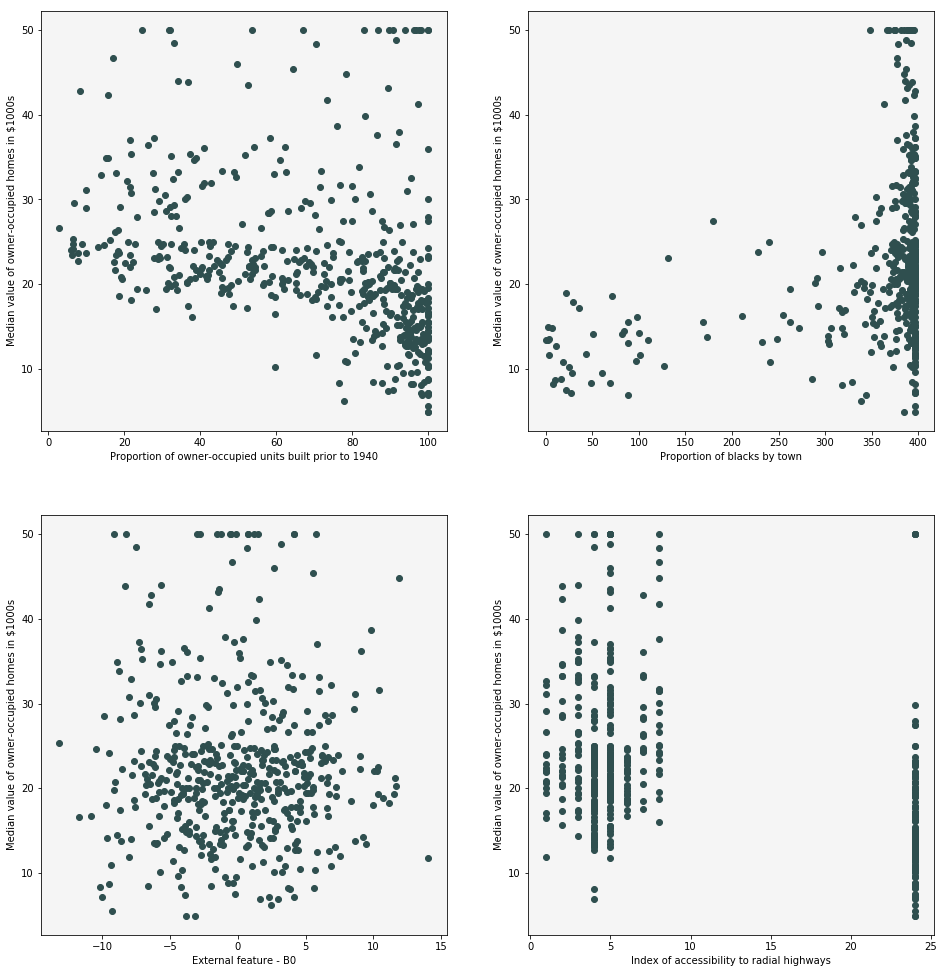

In [20]:
# Irrelevant Features

plt.figure(figsize=(16,17))

# Plot 1 - Age of house by Price
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.subplot(2,2,1)
plt.scatter(data['AGE'],data['MEDV'],c='darkslategrey')
plt.xlabel('Proportion of owner-occupied units built prior to 1940')
plt.ylabel('Median value of owner-occupied homes in $1000s')


# Plot 2 - Proportion of blacks by Price
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.subplot(2,2,2)
plt.scatter(data['B'],data['MEDV'],c='darkslategrey')
plt.xlabel('Proportion of blacks by town')
plt.ylabel('Median value of owner-occupied homes in $1000s')

# Plot 3 - External feature by price
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.subplot(2,2,3)
plt.scatter(data['B0'],data['MEDV'],c='darkslategrey')
plt.xlabel('External feature - B0')
plt.ylabel('Median value of owner-occupied homes in $1000s')

# Plot 4 - Index of accessibility to radial highways by Price
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.subplot(2,2,4)
plt.scatter(data['RAD'],data['MEDV'],c='darkslategrey')
plt.xlabel('Index of accessibility to radial highways')
plt.ylabel('Median value of owner-occupied homes in $1000s')


plt.show()



### Loss Function

In [21]:
# Splitting into test and train

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [22]:
# Linear Regression

model = LinearRegression()
model = model.fit(X_train, Y_train)
YPred = model.predict(X_test)

In [23]:
def loss_function(model, X_test, Y_test):
    
    """
    Calculates loss function as a measure of cross validation for the passed model.
    Takes three inputs: a) the estimated model 
                        b) the test data X
                        c) and the test labels 
    """
    
    X_test = np.concatenate((np.ones((X_test.shape[0],1)), X_test), axis=1)  # Concatenating a column of 1's for intercept
    coeff = np.concatenate((np.matrix(model.intercept_),(np.matrix(model.coef_).T)),axis=0) # Transposing beta values for legal matrix multiplication
    a = np.matrix(Y_test).T - X_test.dot(coeff) # Error term
    loss = (a.T @ a)/X_test.shape[0] # Loss function
    return loss

In [24]:
loss_function(model,X_test,Y_test)

matrix([[15.50634024]])

In [25]:
# Using sklearn mean squared error just to compare with manual loss function

mean_squared_error(YPred, Y_test)

15.506340239659856

### A few simple regressions

In [26]:
# Running simple regression

# 1st Model with 2 features
X1 = data[['RM','LSTAT']] # Highly correlated

In [27]:
# Kfold with K=10 for Linear Regression

def kfold_mse(df,Y,n_split=10):
    """
    Performs K fold cross validation and calculates the mean squared error
    for the passed dataframe(should not have target class) and the target class.
    """
    mse=[]
    for train,test in KFold(n_splits=n_split).split(df):  # Sklearn Kfold method for KFOLD CV - returns train and tet indices
        
        # Defining train and test data for each fold
        X_train, X_test = df.iloc[train], df.iloc[test]
        y_train, y_test = Y.iloc[train], Y.iloc[test]
       
        # Linear regression
        clf = LinearRegression()
        clf.fit(X_train,y_train)
        
        # Call loss function
        mse.append(loss_function(clf,X_test,y_test))
    
    return np.mean(mse)

In [28]:
kfold_mse(X1,Y)

38.38482773415987

In [29]:
# 2nd model with 10 features

X2 = data[['RM','LSTAT','NOX','TAX','PTRATIO','LSTAT_PTRATIO','AGE','CRIM','B0','B8']]

In [30]:
kfold_mse(X2,Y)

37.666164216992996

In [31]:
# All features - Full Model

X3 = data.drop('MEDV',axis=1)


In [32]:
kfold_mse(X3,Y)

24.54700089338337

The best performance is by the full model as it has the lowest mean squared error.

### Find the best model

We have 34 features so we can build 2**34 models which includes all possible combinations of features.

In [33]:
2**34

17179869184

In [34]:
mse=[]

startTime = datetime.now() # To keep track of time the loop runs.

for j in range(1,21):
    for i in range(1,31):
        features = random.sample(list(X.columns),i) # Selects i features at random from X dataframe.
        Y = data['MEDV']
        mse.append(kfold_mse(data[features],Y,n_split=10)) # Kfold CV Linear Regression
print('Time taken','-',datetime.now() - startTime) # Final time

print('Number of mdoels evauated - ',len(mse)) # Total models evaluated

print('Bytes consumed',sys.getsizeof(mse)) # Memory consumed by the number of models


Time taken - 0:00:10.408822
Number of mdoels evauated -  600
Bytes consumed 5496


In [35]:
((5496*17179869184)/600)

157367601725.44

600 models take ~9 seconds. So approximately, 17179869184 models will take 257698037 seconds or 71582 hours.
600 models take 5496 bytes of memory so 17179869184 will take 157367601725 bytes of memory or ~157 GB of memory. It would not be possible to store all results on our computers memory. 

### Forward Selection

In [36]:
X.shape # Feature Set

(506, 34)

In [37]:
# Evaluating best 1-Feature model

mse={} # Dictionary to hold mse value for each feature model
for i in X.columns:  # One feature at a time
    mse[i]=(kfold_mse(data[[i]],Y,n_split=10))  # performing kfold CV with k=10
print(mse)
min(mse.items(), key=lambda x: x[1]) # Finding the feature with least mse

{'CRIM': 77.68794078129832, 'ZN': 79.34700679551293, 'INDUS': 70.44480413675049, 'CHAS': 90.67640673481797, 'NOX': 74.15075363696404, 'RM': 49.96785597294386, 'AGE': 78.25079719122725, 'DIS': 87.49377626526041, 'RAD': 79.91494202512737, 'TAX': 72.28198981387725, 'PTRATIO': 66.72309452760933, 'B': 81.46082359507983, 'LSTAT': 41.82895807216404, 'CRIM_ZN': 79.92335902694523, 'ZN_INDUS': 84.56761988370607, 'NOX_B': 107.79040647799897, 'LSTAT_PTRATIO': 39.542496242406685, 'CRIM_B': 92.04421510521115, 'LSTAT_RM': 42.97119118212706, 'DIS_RM': 80.43701490528852, 'TAX_log': 71.5342450241462, 'ZN_square': 82.48538572307977, 'RAD_RM': 83.73178677538911, 'B0': 92.35177476767741, 'B1': 92.24085084945007, 'B2': 92.37616141497479, 'B3': 92.47887052410934, 'B4': 91.55709430448903, 'B5': 92.22212055707138, 'B6': 92.21884370687681, 'B7': 92.68683434930297, 'B8': 92.42004145363401, 'B9': 92.39437443559447, 'B10': 92.1093086244495}


('LSTAT_PTRATIO', 39.542496242406685)

In [38]:

features = ['LSTAT_PTRATIO'] # First feature as evaluated above

cols = list(X.columns.drop('LSTAT_PTRATIO')) # Droping it from iterator

In [39]:
# Repeating untill all features are included
bic=[]
aic=[]
r=[]

while len(features)!=34:  # Run untill all features are added
    print(features) # Prints selected models at each iteration
    mse={}
    for i in cols:
        mse[i]=(kfold_mse(data[[*features,i]],Y,n_split=10))
    #print(mse,'\n')
    result = min(mse.items(), key=lambda x: x[1])[0]
    features.append(result) # Append to the list
    
    model = sm.ols(formula='MEDV ~ '+' + '.join(features), data=data).fit() # OLS with selected features
    bic.append(model.bic) # Calculate BIC
    aic.append(model.aic) # Calculate AIC
    r.append(model.rsquared_adj) # Calculate Adjusted R squared
    cols.remove(result) # Remove the selected feature from iterator


['LSTAT_PTRATIO']
['LSTAT_PTRATIO', 'RM']
['LSTAT_PTRATIO', 'RM', 'PTRATIO']
['LSTAT_PTRATIO', 'RM', 'PTRATIO', 'LSTAT_RM']
['LSTAT_PTRATIO', 'RM', 'PTRATIO', 'LSTAT_RM', 'LSTAT']
['LSTAT_PTRATIO', 'RM', 'PTRATIO', 'LSTAT_RM', 'LSTAT', 'CRIM']
['LSTAT_PTRATIO', 'RM', 'PTRATIO', 'LSTAT_RM', 'LSTAT', 'CRIM', 'DIS_RM']
['LSTAT_PTRATIO', 'RM', 'PTRATIO', 'LSTAT_RM', 'LSTAT', 'CRIM', 'DIS_RM', 'CHAS']
['LSTAT_PTRATIO', 'RM', 'PTRATIO', 'LSTAT_RM', 'LSTAT', 'CRIM', 'DIS_RM', 'CHAS', 'CRIM_ZN']
['LSTAT_PTRATIO', 'RM', 'PTRATIO', 'LSTAT_RM', 'LSTAT', 'CRIM', 'DIS_RM', 'CHAS', 'CRIM_ZN', 'B0']
['LSTAT_PTRATIO', 'RM', 'PTRATIO', 'LSTAT_RM', 'LSTAT', 'CRIM', 'DIS_RM', 'CHAS', 'CRIM_ZN', 'B0', 'B4']
['LSTAT_PTRATIO', 'RM', 'PTRATIO', 'LSTAT_RM', 'LSTAT', 'CRIM', 'DIS_RM', 'CHAS', 'CRIM_ZN', 'B0', 'B4', 'B7']
['LSTAT_PTRATIO', 'RM', 'PTRATIO', 'LSTAT_RM', 'LSTAT', 'CRIM', 'DIS_RM', 'CHAS', 'CRIM_ZN', 'B0', 'B4', 'B7', 'B6']
['LSTAT_PTRATIO', 'RM', 'PTRATIO', 'LSTAT_RM', 'LSTAT', 'CRIM', 'DIS_RM', '

In [40]:
np.argmin(bic) # Finding the index at which bic was minimum

19

In [41]:
best_model = features[:(np.argmin(bic) + 1)] # Finding best model based on BIC
print(best_model)

['LSTAT_PTRATIO', 'RM', 'PTRATIO', 'LSTAT_RM', 'LSTAT', 'CRIM', 'DIS_RM', 'CHAS', 'CRIM_ZN', 'B0', 'B4', 'B7', 'B6', 'B10', 'B9', 'B8', 'ZN_INDUS', 'ZN_square', 'NOX', 'RAD']


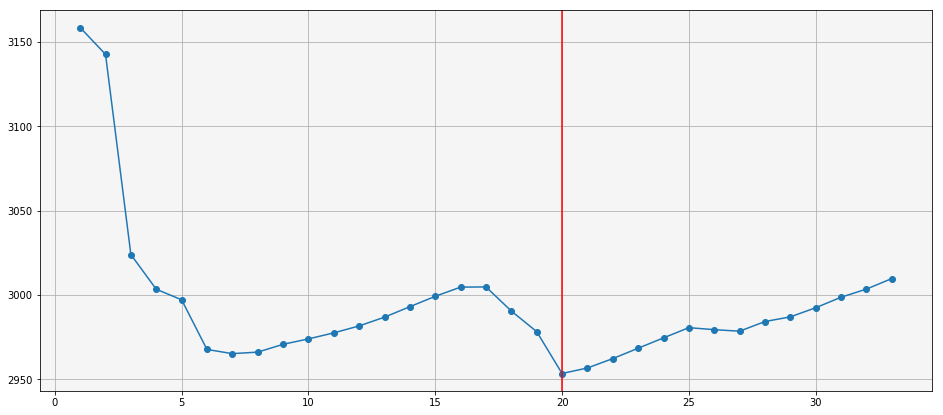

In [42]:
# Plotting BIC vs Number of features

plt.figure(figsize=(16,7))
plt.plot(range(1,34),bic,marker='o')
plt.grid(b=True)
plt.axvline(x=np.argmin(bic)+1,c='r')
plt.show()

In [43]:
# Finding the index at which AIC was minimum
np.argmin(aic)

26

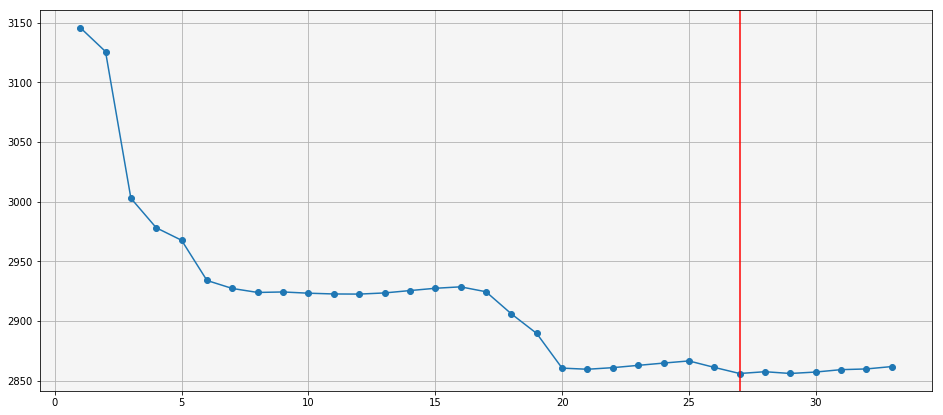

In [44]:
# PLotting AIC vs No of features
plt.figure(figsize=(16,7))
plt.plot(range(1,34),aic,marker='o')
plt.grid(b=True)
plt.axvline(x=np.argmin(aic)+1,c='r')
plt.show()

AIC is also constant after 20 features. hence 20 features is the best measure.

In [45]:
# Finding the index with maximum value of Adjusted rsquare
np.argmax(r)

28

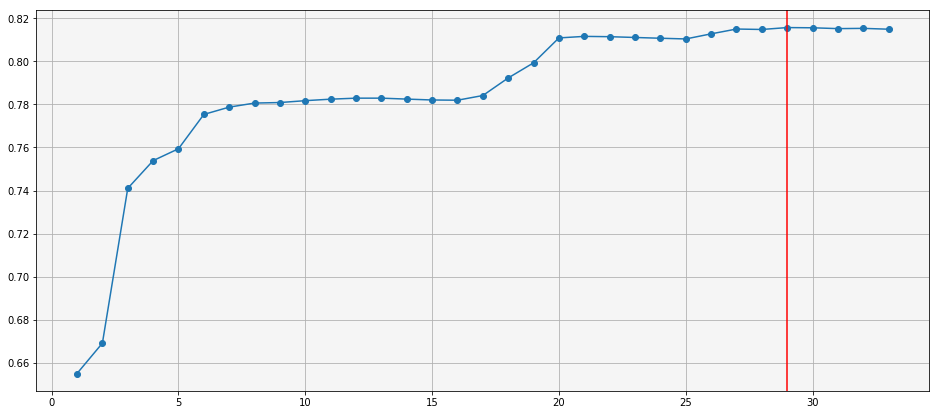

In [46]:
# Plotting adjusted rsquare vs No of features
plt.figure(figsize=(16,7))
plt.plot(range(1,34),r,marker='o')
plt.grid(b=True)
plt.axvline(x=np.argmax(r)+1,c='r')
plt.show()

Choosing BIC as the best measure to evaluate model.

In [48]:
best_model

['LSTAT_PTRATIO',
 'RM',
 'PTRATIO',
 'LSTAT_RM',
 'LSTAT',
 'CRIM',
 'DIS_RM',
 'CHAS',
 'CRIM_ZN',
 'B0',
 'B4',
 'B7',
 'B6',
 'B10',
 'B9',
 'B8',
 'ZN_INDUS',
 'ZN_square',
 'NOX',
 'RAD']

In [49]:
best_model_data = data[best_model]

In [50]:
kfold_mse(best_model_data,Y)

22.48967170678288

### Principle Components

In [51]:
# PCA on raw features

X = data.drop('MEDV',axis=1)
pca = PCA(n_components=34)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=34, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [52]:
# Explained variance by each component

explained_variance = list(pca.explained_variance_)

In [53]:
var = pd.DataFrame()
var['Components'] = range(1,35)
var['explained_variance'] = explained_variance


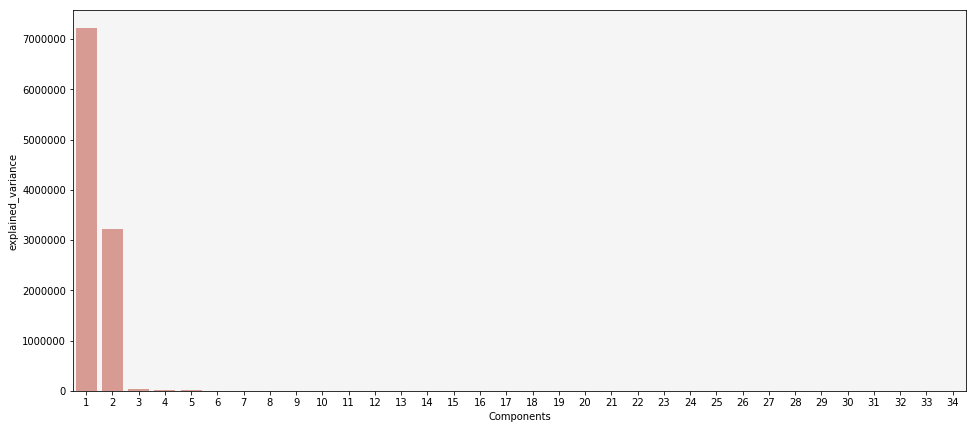

In [54]:
plt.figure(figsize=(16,7))
sns.barplot(x="Components", y="explained_variance", data=var, color="salmon", saturation=.5)

In [55]:
# Proportion of variance explained by each principle component

proportion_explained_variance = list(pca.explained_variance_ratio_)
var['proportion_explained_variance'] = proportion_explained_variance

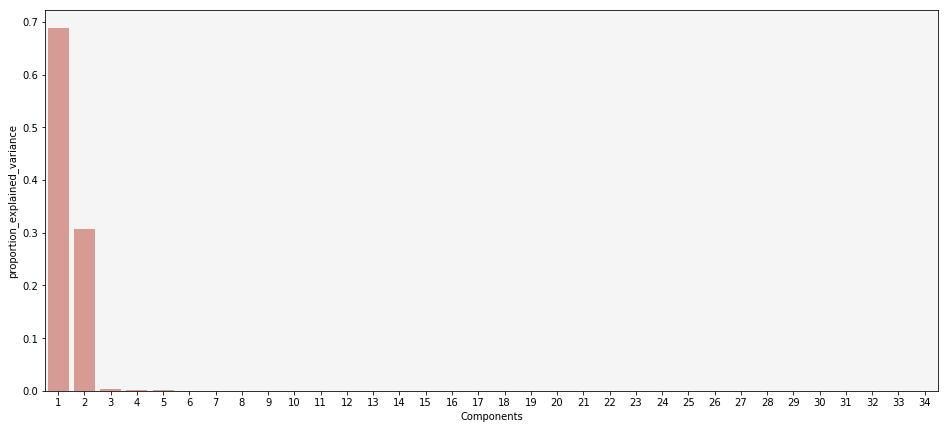

In [56]:
plt.figure(figsize=(16,7))
sns.barplot(x="Components", y="proportion_explained_variance", data=var, color="salmon", saturation=.5)

In [57]:
cumulative_explained_variance = list(pca.explained_variance_ratio_.cumsum())
var['cumulative_explained_variance'] = cumulative_explained_variance
var

,Components,explained_variance,proportion_explained_variance,cumulative_explained_variance
0,1,7.212079e+06,6.876010e-01,0.687601
1,2,3.221240e+06,3.071136e-01,0.994715
2,3,3.225703e+04,3.075391e-03,0.997790
3,4,1.032608e+04,9.844905e-04,0.998774
4,5,7.583269e+03,7.229902e-04,0.999497
5,6,3.352565e+03,3.196342e-04,0.999817
6,7,7.177881e+02,6.843405e-05,0.999886
7,8,4.980363e+02,4.748287e-05,0.999933
8,9,2.178277e+02,2.076773e-05,0.999954
9,10,8.732562e+01,8.325640e-06,0.999962


We can see that majority of the variance is explained by the first two principle components 

In [58]:
# Rotating the data to be parallel to x axis

In [59]:
cols = []
for i in range(1,35):
    cols.append('pc'+str(i)) 

In [60]:
X.shape

(506, 34)

In [61]:
rotated = pd.DataFrame(pca.fit_transform(X),columns=cols) # Dataframe with principle components

In [62]:
rotated.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34
0,-919.398060,-502.410851,177.431139,-67.798460,4.435249,-11.717956,14.519054,25.134082,-1.438443,-0.193011,...,-0.428803,-2.637331,-2.695439,-1.329838,-0.379919,-0.531879,-0.054611,-0.012523,0.043065,0.002324
1,-856.476800,-822.909701,168.166990,30.824700,23.699671,-40.893680,-2.099611,-0.788325,-20.798492,-2.731305,...,-2.079690,0.490575,-0.490741,0.118409,-0.123738,-0.118633,-0.010976,0.032098,0.051946,0.006437
2,-859.040369,-820.787960,220.208635,-48.285230,41.208688,-48.369847,-6.164920,3.041193,-8.528070,1.072797,...,-1.777460,0.192429,0.403460,-0.264144,-0.621781,0.338044,-0.073138,0.002326,0.050299,-0.000048
3,-858.149431,-819.698959,244.962740,-54.294045,51.294095,-49.588430,-16.891552,-7.399489,1.117771,4.885926,...,-4.941064,0.569016,0.112997,-0.420516,-0.151288,0.406432,-0.102025,0.057974,0.089709,0.004276
4,-842.512163,-818.302700,219.488028,-15.095863,42.582585,-45.796877,-15.349693,-11.231651,-4.164587,-1.360259,...,-4.034750,-0.002110,0.461327,-0.041440,-0.688221,0.484592,-0.045852,0.118923,0.085390,0.003825


In [63]:
# Starting with the first, added pca's one by one.

features = list(rotated.columns)
mse_list=[]
for i in range(1,35):
    mse=(kfold_mse(rotated[features[:i]],Y,n_split=10))
    mse_list.append(mse)

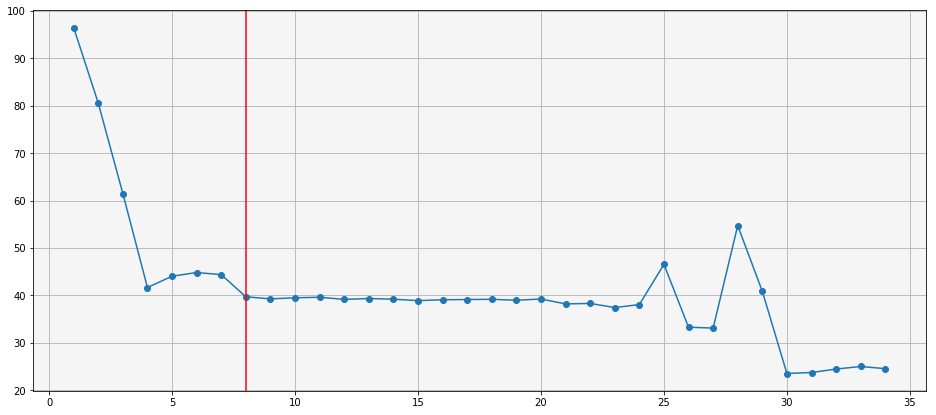

In [64]:
# Plotting MSE vs PCAs
plt.figure(figsize=(16,7))
plt.plot(range(1,35),mse_list,marker='o')
plt.grid(b=True)
plt.axvline(x=8,c='r')
plt.show()

In [65]:
# Finding minimum mse
np.argmin(mse_list)

29

30 components give the least cross validated MSE. However, the MSE is pretty much stble after 8 PC's

In [66]:
def normalize_feature(array):
    """
    Normalizes a passed feature based on xn = x − xbar / sdx
    """
    mean = array.mean() #mean
    std = array.std() # standard deviation
    
    norm_feature = (array - mean )/std
    
    return norm_feature

In [67]:
# A dataframe with normalized features - Does not include target class
normalized_df = pd.DataFrame()
for i in X.columns:
    normalized_feature = normalize_feature(X[i])
    normalized_df[i]=normalized_feature

In [68]:
cols = []
for i in range(1,35):
    cols.append('pc_normalized'+str(i)) 

In [69]:
# Rotating the data

rotated_normalized = pd.DataFrame(pca.fit_transform(normalized_df),columns=cols)

In [70]:
features = list(rotated_normalized.columns)
mse_list_normalized=[]
for i in range(1,35):
    mse=(kfold_mse(rotated_normalized[features[:i]],Y,n_split=10))
    mse_list_normalized.append(mse)

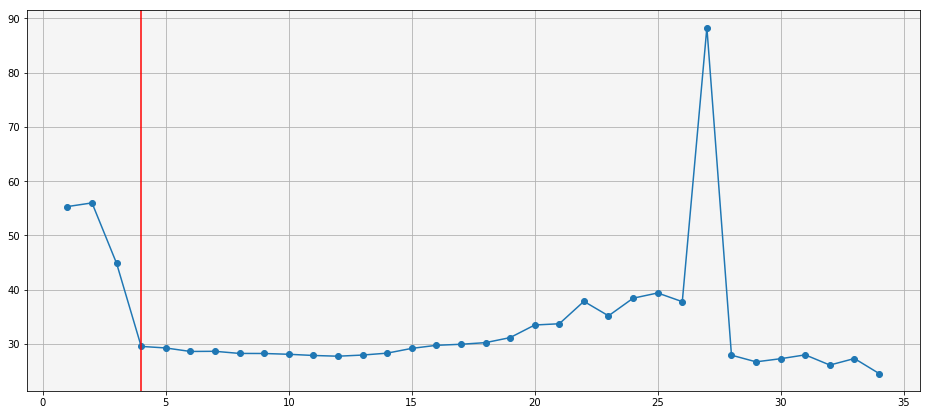

In [71]:
plt.figure(figsize=(16,7))
plt.plot(range(1,35),mse_list_normalized,marker='o')
plt.grid(b=True)
plt.axvline(x=4,c='r')
plt.show()

In [72]:
np.argmin(mse_list)

29

The best model is with 4 PCA components as seen from the graph above. After 4 components the MSE remains the same and adding those would only mean using up memeory without adding any information. We see a peak at PCA 26 which may be because of multicollinearity or other voiled assumptions of Linear Regression.

### Whats the best solution?

In [73]:
df = pd.DataFrame(columns=['Model', 'Features','MSE','Comments'])
df = df.append(pd.Series(['Full Model', '34','24.5','Easiest to do'], index=['Model', 'Features','MSE','Comments']), ignore_index=True)

In [74]:
df = df.append(pd.Series(['Forward Selection Model', np.argmin(bic)+1,'22.58','Straightforward to interpret'], index=['Model', 'Features','MSE','Comments']), ignore_index=True)

In [75]:
df = df.append(pd.Series(['PCA on raw data', '8','41','Most compact'], index=['Model', 'Features','MSE','Comments']), ignore_index=True)

In [76]:
df = df.append(pd.Series(['PCA on normalized data', '4','30','Most precise'], index=['Model', 'Features','MSE','Comments']), ignore_index=True)

In [77]:
df

,Model,Features,MSE,Comments
0,Full Model,34,24.5,Easiest to do
1,Forward Selection Model,20,22.58,Straightforward to interpret
2,PCA on raw data,8,41,Most compact
3,PCA on normalized data,4,30,Most precise
